# Pouch cell model

In this notebook we compare the solutions of two reduced-order models of a lithium-ion pouch cell with the full solution obtained using COMSOL. This example is based on the results in [[6]](#References). The code used to produce the results in [[6]](#References) can be found [here](https://github.com/rtimms/asymptotic-pouch-cell).

The full model is based on the Doyle-Fuller-Newman model [[2]](#References) and, in the interest of simplicity, considers a one-dimensional current collector (i.e. variation in one of the current collector dimensions is ignored), resulting in a 2D macroscopic model.

The first of the reduced order models, which is applicable in the limit of large conductivity in the current collectors, solves a one-dimensional problem in the current collectors coupled to a one-dimensional DFN model describing the through-cell electrochemistry at each point. We refer to this as a 1+1D model, though since the DFN is already a pseudo-two-dimensional model, perhaps it is more properly a 1+1+1D model.

The second reduced order model, which is applicable in the limit of very large conductivity in the current collectors, solves a single (averaged) one-dimensional DFN model for the through-cell behaviour and an uncoupled problem for the distribution of potential in the current collectors (from which the resistance and heat source can be calculated). We refer to this model as the DFNCC, where the "CC" indicates the additional (uncoupled) current collector problem.

All of the model equations, and derivations of the reduced-order models, can be found in [[6]](#References).

## Solving the reduced-order pouch cell models in PyBaMM

We begin by importing PyBaMM along with the other packages required in this notebook

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

# increase recursion limit for large expression trees
sys.setrecursionlimit(100000)

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We then need to load up the appropriate models. For the DFNCC we require a 1D model of the current collectors and an average 1D DFN model for the through-cell electrochemistry. The 1+1D pouch cell model is built directly into PyBaMM and are accessed by passing the model option "dimensionality" which can be 1 or 2, corresponding to 1D or 2D current collectors. This option can be passed to any existing electrochemical model (e.g. [SPM](./SPM.ipynb), [SPMe](./SPMe.ipynb), [DFN](./DFN.ipynb)). Here we choose the DFN model. 

For both electrochemical models we choose an "x-lumped" thermal model, meaning we assume that the temperature is uniform in the through-cell direction $x$, but account for the variation in temperature in the transverse direction $z$.

In [2]:
cc_model = pybamm.current_collector.EffectiveResistance({"dimensionality": 1})
dfn_av = pybamm.lithium_ion.DFN({"thermal": "x-lumped"}, name="Average DFN")
dfn = pybamm.lithium_ion.DFN(
    {"current collector": "potential pair", "dimensionality": 1, "thermal": "x-lumped"},
    name="1+1D DFN",
)

/Users/vsulzer/Documents/Energy_storage/PyBaMM/pybamm/models/full_battery_models/base_battery_model.py:456: UserWarning: 1+1D Thermal models are only valid if both tabs are placed at the top of the cell.
  warnings.warn(


We then add the models to a dictionary for easy access later

In [3]:
models = {"Current collector": cc_model, "Average DFN": dfn_av, "1+1D DFN": dfn}

Next we update the parameters to match those used in the COMSOL simulation. In particular, we set the current to correspond to a 3C discharge and assume uniform Newton cooling on all boundaries.

In [4]:
param = dfn.default_parameter_values
I_1C = param["Nominal cell capacity [A.h]"]  # 1C current is cell capacity multipled by 1 hour
param.update(
    {
        "Current function [A]": I_1C * 3,       
        "Negative electrode diffusivity [m2.s-1]": 3.9 * 10 ** (-14),
        "Positive electrode diffusivity [m2.s-1]": 10 ** (-13),
        "Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 10,
        "Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 10,
        "Negative tab heat transfer coefficient [W.m-2.K-1]": 10,
        "Positive tab heat transfer coefficient [W.m-2.K-1]": 10,
        "Edge heat transfer coefficient [W.m-2.K-1]": 10,
    }
)

In this example we choose to discretise in space using 16 nodes per domain.

In [5]:
var = pybamm.standard_spatial_vars
npts = 16
var_pts = {
    var.x_n: npts,
    var.x_s: npts,
    var.x_p: npts,
    var.r_n: npts,
    var.r_p: npts,
    var.z: npts,
}

Before solving the models we load the COMSOL data so that we can request the output at the times in the COMSOL solution

In [6]:
comsol_results_path = pybamm.get_parameters_filepath(
    "input/comsol_results/comsol_1plus1D_3C.pickle"
)
comsol_variables = pickle.load(open(comsol_results_path, "rb"))

Next we loop over the models, creating and solving a simulation for each.

In [7]:
simulations = {}
solutions = {}  # store solutions in a separate dict for easy access later
for name, model in models.items():
    sim = pybamm.Simulation(model, parameter_values=param, var_pts=var_pts)
    simulations[name] = sim  # store simulation for later
    if name == "Current collector":
        # model is independent of time, so just solve arbitrarily at t=0 using 
        # the default algebraic solver
        t_eval = np.array([0])
        solutions[name] = sim.solve(t_eval=t_eval)        
    else:
        # solve at COMSOL times using Casadi solver in "fast" mode
        t_eval = comsol_variables["time"]       
        solutions[name] = sim.solve(solver=pybamm.CasadiSolver(mode="fast"), t_eval=t_eval)

## Creating the COMSOL model

In this section we show how to create a PyBaMM "model" from the COMSOL solution. If you are just interested in seeing the comparison the skip ahead to the section "Comparing the full and reduced-order models".


To create a PyBaMM model from the COMSOL data we must create a `pybamm.Function` object for each variable. We do this by interpolating in space to match the PyBaMM mesh and then creating a function to interpolate in time. The following cell defines the function that handles the creation of the `pybamm.Function` object.

In [8]:
# set up times
tau = param.evaluate(dfn.param.tau_discharge)
comsol_t = comsol_variables["time"]
pybamm_t = comsol_t / tau
# set up space
mesh = simulations["1+1D DFN"].mesh
L_z = param.evaluate(dfn.param.L_z)
pybamm_z = mesh["current collector"].nodes
z_interp = pybamm_z * L_z

    
def get_interp_fun_curr_coll(variable_name):
    """
    Create a :class:`pybamm.Function` object using the variable (interpolate in space 
    to match nodes, and then create function to interpolate in time)
    """

    comsol_z = comsol_variables[variable_name + "_z"]
    variable = comsol_variables[variable_name]
    variable = interp.interp1d(comsol_z, variable, axis=0, kind="linear")(z_interp)

    # Make sure to use dimensional time
    fun = pybamm.Interpolant(
        comsol_t,
        variable.T,
        pybamm.t * tau,
        name=variable_name + "_comsol"
    )
    fun.domain = "current collector"
    fun.mesh = mesh.combine_submeshes("current collector")
    fun.secondary_mesh = None
    
    return fun

We then pass the variables of interest to the interpolating function

In [9]:
comsol_voltage = pybamm.Interpolant(
    comsol_t, 
    comsol_variables["voltage"],
    pybamm.t * tau,
    name="voltage_comsol",
)
comsol_voltage.mesh = None
comsol_voltage.secondary_mesh = None
comsol_phi_s_cn = get_interp_fun_curr_coll("phi_s_cn")
comsol_phi_s_cp = get_interp_fun_curr_coll("phi_s_cp")
comsol_current = get_interp_fun_curr_coll("current")
comsol_temperature = get_interp_fun_curr_coll("temperature")

and add them to a `pybamm.BaseModel` object

In [10]:
comsol_model = pybamm.BaseModel()
comsol_model.variables = {
    "Terminal voltage [V]": comsol_voltage,
    "Negative current collector potential [V]": comsol_phi_s_cn,
    "Positive current collector potential [V]": comsol_phi_s_cp,
    "Current collector current density [A.m-2]": comsol_current,
    "X-averaged cell temperature [K]": comsol_temperature,
    # Add spatial variables to match pybamm model
    "z": simulations["1+1D DFN"].built_model.variables["z"],
    "z [m]": simulations["1+1D DFN"].built_model.variables["z [m]"],   
}

We then add the solution object from the 1+1D model. This is just so that PyBaMM uses the same (dimensionless) times behind the scenes when dealing with COMSOL model and the reduced-order models: the variables in `comsol_model.variables` are functions of time only that return the (interpolated in space) COMSOL solution. We also need to update the time and length scales for the COMSOL model so that any dimensionless variables are scaled correctly. 

In [11]:
comsol_model.timescale = simulations["1+1D DFN"].model.timescale
comsol_model.length_scales = simulations["1+1D DFN"].model.length_scales
comsol_solution = pybamm.Solution(solutions["1+1D DFN"].t, solutions["1+1D DFN"].y, comsol_model, {})

## Comparing the full and reduced-order models

The DFNCC requires some post-processing to extract the solution variables. In particular, we need to pass the current and voltage from the average DFN model to the current collector model in order to compute the distribution of the potential in the current collectors and to account for the effect of the current collector resistance in the terminal voltage. 

This process is automated by the method `post_process` which accepts the current collector solution object, the parameters and the voltage and current from the average DFN model. The results are stored in the dictionary `dfncc_vars`

In [12]:
V_av = solutions["Average DFN"]["Terminal voltage"]
I_av = solutions["Average DFN"]["Total current density"]

dfncc_vars = cc_model.post_process(
    solutions["Current collector"], param, V_av, I_av
)

Next we create a function to create some custom plots. For a given variable the plots will show: (a) the COMSOL results as a function of position in the current collector $z$ and time $t$; (b) a comparison of the full and reduced-order models and a sequence of times; (c) the time-averaged error between the full and reduced-order models as a function of space; and (d) the space-averaged error between the full and reduced-order models as a function of time.

In [13]:
def plot(
    t_plot,
    z_plot,
    t_slices,
    var_name,
    units,
    comsol_var_fun,
    dfn_var_fun,
    dfncc_var_fun,
    param,
    cmap="viridis",
):
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 7))
    fig.subplots_adjust(
        left=0.15, bottom=0.1, right=0.95, top=0.95, wspace=0.4, hspace=0.8
    )
    # plot comsol var
    comsol_var = comsol_var_fun(t=t_plot, z=z_plot)
    comsol_var_plot = ax[0, 0].pcolormesh(
        z_plot * 1e3, t_plot, np.transpose(comsol_var), shading="gouraud", cmap=cmap
    )
    if "cn" in var_name:
        format = "%.0e"
    elif "cp" in var_name:
        format = "%.0e"
    else:
        format = None
    fig.colorbar(
        comsol_var_plot,
        ax=ax,
        format=format,
        location="top",
        shrink=0.42,
        aspect=20,
        anchor=(0.0, 0.0),
    )

    # plot slices
    ccmap = plt.get_cmap("inferno")
    for ind, t in enumerate(t_slices):
        color = ccmap(float(ind) / len(t_slices))
        comsol_var_slice = comsol_var_fun(t=t, z=z_plot)
        dfn_var_slice = dfn_var_fun(t=t, z=z_plot)
        dfncc_var_slice = dfncc_var_fun(t=np.array([t]), z=z_plot)
        ax[0, 1].plot(
            z_plot * 1e3, comsol_var_slice, "o", fillstyle="none", color=color
        )
        ax[0, 1].plot(
            z_plot * 1e3,
            dfn_var_slice,
            "-",
            color=color,
            label="{:.0f} s".format(t_slices[ind]),
        )
        ax[0, 1].plot(z_plot * 1e3, dfncc_var_slice, ":", color=color)
    # add dummy points for legend of styles
    comsol_p, = ax[0, 1].plot(np.nan, np.nan, "ko", fillstyle="none")
    pybamm_p, = ax[0, 1].plot(np.nan, np.nan, "k-", fillstyle="none")
    dfncc_p, = ax[0, 1].plot(np.nan, np.nan, "k:", fillstyle="none")

    # compute errors
    dfn_var = dfn_var_fun(t=t_plot, z=z_plot)
    dfncc_var = dfncc_var_fun(t=t_plot, z=z_plot)
    error = np.abs(comsol_var - dfn_var)
    error_bar = np.abs(comsol_var - dfncc_var)

    # plot time averaged error
    ax[1, 0].plot(z_plot * 1e3, np.mean(error, axis=1), "k-", label=r"$1+1$D")
    ax[1, 0].plot(z_plot * 1e3, np.mean(error_bar, axis=1), "k:", label="DFNCC")

    # plot z averaged error
    ax[1, 1].plot(t_plot, np.mean(error, axis=0), "k-", label=r"$1+1$D")
    ax[1, 1].plot(t_plot, np.mean(error_bar, axis=0), "k:", label="DFNCC")

    # set ticks
    ax[0, 0].tick_params(which="both")
    ax[0, 1].tick_params(which="both")
    ax[1, 0].tick_params(which="both")
    if var_name in ["$\mathcal{I}^*$"]:
        ax[1, 0].set_yscale("log")
        ax[1, 0].set_yticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-2, 1e-1, 1]
    else:
        ax[1, 0].ticklabel_format(style="sci", scilimits=(-2, 2), axis="y")
    ax[1, 1].tick_params(which="both")
    if var_name in ["$\phi^*_{\mathrm{s,cn}}$", "$\phi^*_{\mathrm{s,cp}} - V^*$"]:
        ax[1, 0].ticklabel_format(style="sci", scilimits=(-2, 2), axis="y")
    else:
        ax[1, 1].set_yscale("log")
        ax[1, 1].set_yticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-2, 1e-1, 1]

    # set labels
    ax[0, 0].set_xlabel(r"$z^*$ [mm]")
    ax[0, 0].set_ylabel(r"$t^*$ [s]")
    ax[0, 0].set_title(r"{} {}".format(var_name, units), y=1.5)
    ax[0, 1].set_xlabel(r"$z^*$ [mm]")
    ax[0, 1].set_ylabel(r"{}".format(var_name))
    ax[1, 0].set_xlabel(r"$z^*$ [mm]")
    ax[1, 0].set_ylabel("Time-averaged" + "\n" + r"absolute error {}".format(units))
    ax[1, 1].set_xlabel(r"$t^*$ [s]")
    ax[1, 1].set_ylabel("Space-averaged" + "\n" + r"absolute error {}".format(units))

    ax[0, 0].text(-0.1, 1.6, "(a)", transform=ax[0, 0].transAxes)
    ax[0, 1].text(-0.1, 1.6, "(b)", transform=ax[0, 1].transAxes)
    ax[1, 0].text(-0.1, 1.2, "(c)", transform=ax[1, 0].transAxes)
    ax[1, 1].text(-0.1, 1.2, "(d)", transform=ax[1, 1].transAxes)

    leg1 = ax[0, 1].legend(
        bbox_to_anchor=(0, 1.1, 1.0, 0.102),
        loc="lower left",
        borderaxespad=0.0,
        ncol=3,
        mode="expand",
    )

    leg2 = ax[0, 1].legend(
        [comsol_p, pybamm_p, dfncc_p],
        ["COMSOL", r"$1+1$D", "DFNCC"],
        bbox_to_anchor=(0, 1.5, 1.0, 0.102),
        loc="lower left",
        borderaxespad=0.0,
        ncol=3,
        mode="expand",
    )
    ax[0, 1].add_artist(leg1)

    ax[1, 0].legend(
        bbox_to_anchor=(0.0, 1.1, 1.0, 0.102),
        loc="lower right",
        borderaxespad=0.0,
        ncol=3,
    )
    ax[1, 1].legend(
        bbox_to_anchor=(0.0, 1.1, 1.0, 0.102),
        loc="lower right",
        borderaxespad=0.0,
        ncol=3,
    )

We then set up the times and points in space to use in the plots 

In [14]:
t_plot = comsol_t
z_plot = z_interp
t_slices = np.array([600, 1200, 1800, 2400, 3000]) / 3

and plot the negative current collector potential

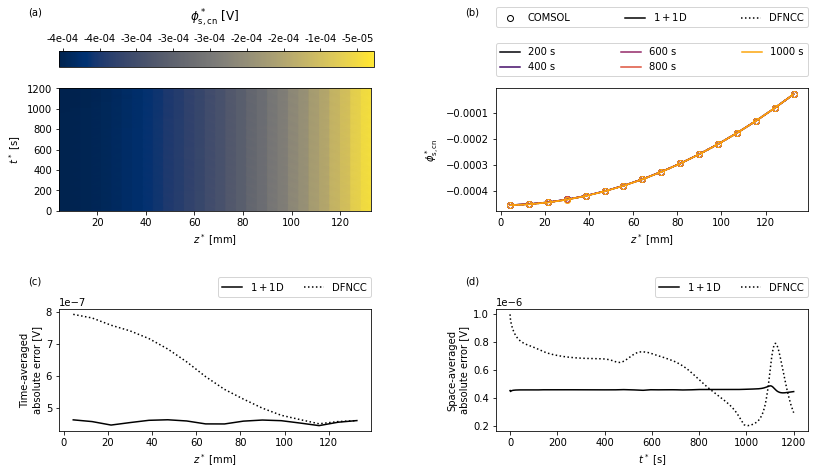

In [15]:
var = "Negative current collector potential [V]"
comsol_var_fun = comsol_solution[var]
dfn_var_fun = solutions["1+1D DFN"][var]

dfncc_var_fun = dfncc_vars[var]
plot(
    t_plot,
    z_plot,
    t_slices,
    "$\phi^*_{\mathrm{s,cn}}$",
    "[V]",
    comsol_var_fun,
    dfn_var_fun,
    dfncc_var_fun,
    param,
    cmap="cividis",
)

the positive current collector potential with respect to terminal voltage

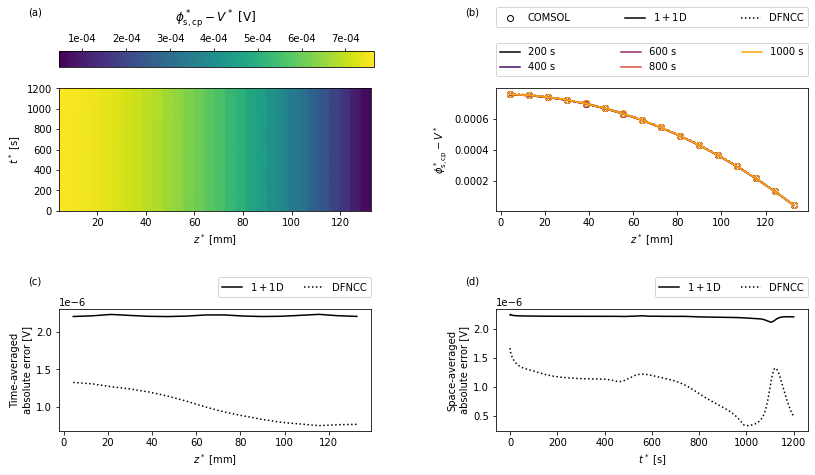

In [16]:
var = "Positive current collector potential [V]"
comsol_var = comsol_solution[var]
V_comsol = comsol_solution["Terminal voltage [V]"]


def comsol_var_fun(t, z):
    return comsol_var(t=t, z=z) - V_comsol(t=t)


dfn_var = solutions["1+1D DFN"][var]
V = solutions["1+1D DFN"]["Terminal voltage [V]"]


def dfn_var_fun(t, z):
    return dfn_var(t=t, z=z) - V(t=t)


dfncc_var =  dfncc_vars[var]
V_dfncc = dfncc_vars["Terminal voltage [V]"]

def dfncc_var_fun(t, z):
    return dfncc_var(t=t, z=z) - V_dfncc(t)


plot(
    t_plot,
    z_plot,
    t_slices,
    "$\phi^*_{\mathrm{s,cp}} - V^*$",
    "[V]",
    comsol_var_fun,
    dfn_var_fun,
    dfncc_var_fun,
    param,
    cmap="viridis",
)

the through-cell current 

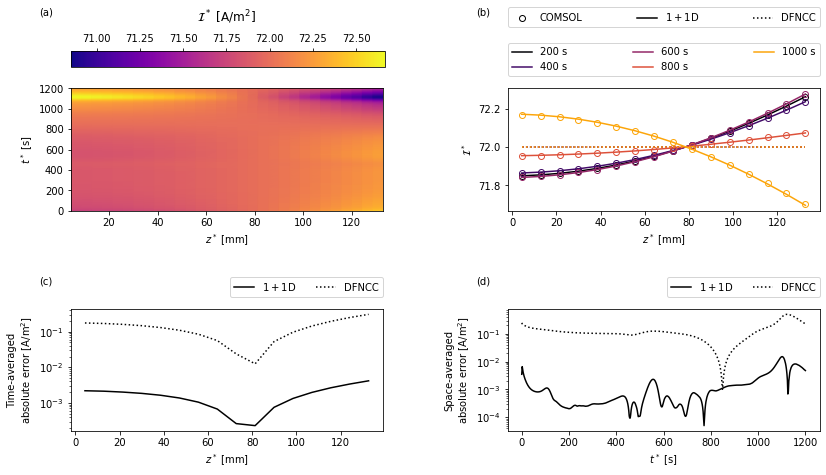

In [17]:
var = "Current collector current density [A.m-2]"
comsol_var_fun = comsol_solution[var]
dfn_var_fun = solutions["1+1D DFN"][var]

I_av = solutions["Average DFN"][var]


def dfncc_var_fun(t, z):
    "In the DFNCC the current is just the average current"
    return np.transpose(np.repeat(I_av(t)[:, np.newaxis], len(z), axis=1))


plot(
    t_plot,
    z_plot,
    t_slices,
    "$\mathcal{I}^*$",
    "[A/m${}^2$]",
    comsol_var_fun,
    dfn_var_fun,
    dfncc_var_fun,
    param,
    cmap="plasma",
)

and the temperature with respect to reference temperature

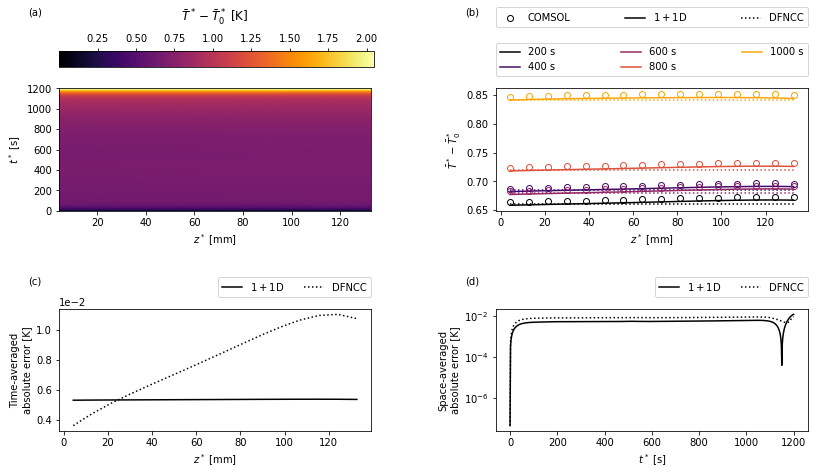

In [18]:
T_ref = param.evaluate(dfn.param.T_ref)
var = "X-averaged cell temperature [K]"
comsol_var = comsol_solution[var]


def comsol_var_fun(t, z):
    return comsol_var(t=t, z=z) - T_ref


dfn_var = solutions["1+1D DFN"][var]


def dfn_var_fun(t, z):
    return dfn_var(t=t, z=z) - T_ref


T_av = solutions["Average DFN"][var]


def dfncc_var_fun(t, z):
    "In the DFNCC the temperature is just the average temperature"
    return np.transpose(np.repeat(T_av(t)[:, np.newaxis], len(z), axis=1)) - T_ref


plot(
    t_plot,
    z_plot,
    t_slices,
    "$\\bar{T}^* - \\bar{T}_0^*$",
    "[K]",
    comsol_var_fun,
    dfn_var_fun,
    dfncc_var_fun,
    param,
    cmap="inferno",
)

We see that the electrical conductivity of the current collectors is sufficiently
high that the potentials remain fairly uniform in space, and both the 1+1D DFN and DFNCC models are able to accurately capture the potential distribution in the current collectors.


In the plot of the current we see that positioning both tabs at the top of the cell means that for most of the simulation the current preferentially travels through the upper part of the cell. Eventually, as the cell continues to discharge, this part becomes more (de)lithiated until the resultant local increase in through-cell resistance is sufficient for it to become preferential for the current to travel further along the current collectors and through the lower part of the cell. This behaviour is well captured by the 1+1D model. In the DFNCC formulation the through-cell current density is assumed uniform,
so the greatest error is found at the ends of the current collectors where the current density deviates most from its average.

For the parameters used in this example we find that the temperature exhibits a relatively weak variation along the length of the current collectors.  

## References

The relevant papers for this notebook are:

In [19]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[3] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[4] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/